In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns

/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out_encoder = self.encoder(x)
        out_decoder = self.decoder(out_encoder)
        return out_encoder, out_decoder

In [4]:
# Load dataset
X_train = pd.read_csv('./data/UCI_HAR/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('./data/UCI_HAR/train/y_train.txt', delim_whitespace=True, header=None).squeeze()
X_test = pd.read_csv('./data/UCI_HAR/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('./data/UCI_HAR/test/y_test.txt', delim_whitespace=True, header=None).squeeze()

y_train = y_train-1
y_test = y_test-1

print("Train dataset shapes: {}, {}".format(X_train.shape, y_train.shape))
print("Test dataset shapes: {}, {}".format(X_test.shape, y_test.shape))

# Convert to Tensor
train_dataset = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = TensorDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).long())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Train dataset shapes: (7352, 561), (7352,)
Test dataset shapes: (2947, 561), (2947,)


In [5]:
# Define the model parameters
input_size = X_train.shape[1]
encoding_size = 128
model = Autoencoder(input_size, encoding_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [6]:
# Train the model
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for x,y in train_loader:
        optimizer.zero_grad()
        output_encoder, output_decoder = model(x)
        loss = criterion(output_decoder, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {} Loss: {}".format(epoch+1, running_loss/len(X_train)))

Epoch 1 Loss: 0.010208056155304394
Epoch 2 Loss: 0.010093878334442861
Epoch 3 Loss: 0.00979764477407582
Epoch 4 Loss: 0.009122750850574755
Epoch 5 Loss: 0.007959852937580583
Epoch 6 Loss: 0.006588686934557781
Epoch 7 Loss: 0.005514748078305781
Epoch 8 Loss: 0.004877693035008469
Epoch 9 Loss: 0.004543920012111892
Epoch 10 Loss: 0.004376276962710412


## Check difference in similarity of representations

In [7]:
random.seed(8)
rand_nums = random.sample(range(len(X_test)), 100)
X_rand_users = X_test.iloc[rand_nums]
y_rand_users = y_test.iloc[rand_nums]

simulated_queries = pd.concat([X_rand_users]*50)
simulated_queries[simulated_queries.columns] = np.random.uniform(-1,1,size=len(simulated_queries)*simulated_queries.shape[1]).reshape(len(simulated_queries),-1)
simulated_queries = simulated_queries

noise_queries = pd.concat([X_rand_users]*50)
rand_noise = np.random.uniform(-0.01,0.01,size=noise_queries.shape[0]*noise_queries.shape[1]).reshape(noise_queries.shape[0],-1)
noise_queries = noise_queries + rand_noise
noise_queries = noise_queries.clip(-1,1)

In [8]:
out_encoder_train, out_decoder_train = model(torch.from_numpy(X_train.values).float())
out_encoder_test, out_decoder_test = model(torch.from_numpy(X_test.values).float())
out_encoder_rand, out_decoder_rand = model(torch.from_numpy(simulated_queries.values).float())
out_encoder_noise, out_decoder_noise = model(torch.from_numpy(noise_queries.values).float())

-------- Cosine Similarity on Raw Input --------
Median cos sim across train data 9.475409776444476
Median cos sim across test data 9.170582102798887
Median cos sim across random data 892.2619791416257
Median cos sim across noise-added data 891.6365208190596
--------
Variance in cos sim across train data 1.6186010437124179
Variance in cos sim across test data 1.0382450741126166
Variance in cos sim across random data 46715.584542939796
Variance in cos sim across noise-added data 46724.88350197094


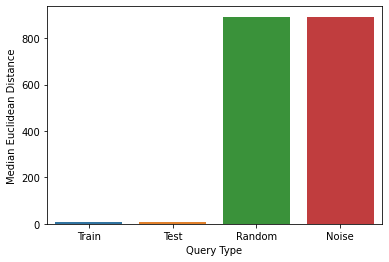

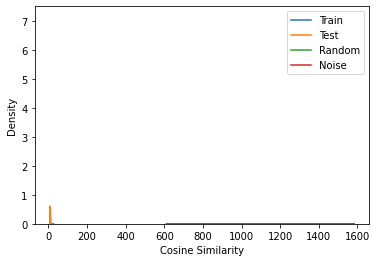

-------- Cosine Similarity on Encodings --------
Median cos sim across train data 8.119455
Median cos sim across test data 7.7378917
Median cos sim across random data 1.7271175
Median cos sim across noise-added data 8.0808525
--------
Variance in cos sim across train data 8.366408
Variance in cos sim across test data 5.3234477
Variance in cos sim across random data 0.058986235
Variance in cos sim across noise-added data 4.714368


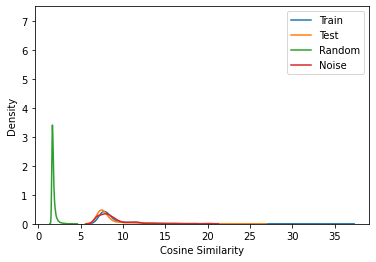

In [20]:
# Difference between representations
cos_train = np.mean(pairwise_distances(X_train.values, metric="euclidean"), axis=1)
cos_test = np.mean(pairwise_distances(X_test.values, metric="euclidean"), axis=1)
cos_rand = np.mean(pairwise_distances(simulated_queries.reset_index().values, metric="euclidean"), axis=1)
cos_noise = np.mean(pairwise_distances(noise_queries.reset_index().values, metric="euclidean"), axis=1)
print('-------- Cosine Similarity on Raw Input --------')
print('Median cos sim across train data', np.median(cos_train))
print('Median cos sim across test data', np.median(cos_test))
print('Median cos sim across random data', np.median(cos_rand))
print('Median cos sim across noise-added data', np.median(cos_noise))
print('--------')
print('Variance in cos sim across train data', np.var(cos_train))
print('Variance in cos sim across test data', np.var(cos_test))
print('Variance in cos sim across random data', np.var(cos_rand))
print('Variance in cos sim across noise-added data', np.var(cos_noise))

sns.barplot(x=['Train', 'Test', 'Random', 'Noise'], y=[np.median(cos_train), np.median(cos_test), np.median(cos_rand), np.median(cos_noise)])
plt.xlabel('Query Type')
plt.ylabel('Median Euclidean Distance')
plt.savefig('./results/UCI_HAR/defense/median_euc_dist.png', dpi=300)
plt.show()

sns.kdeplot(cos_train, label='Train')
sns.kdeplot(cos_test, label='Test')
sns.kdeplot(cos_rand, label='Random')
sns.kdeplot(cos_noise, label='Noise')
plt.legend()
plt.xlabel('Cosine Similarity')
plt.ylim(0,7.5)
plt.show()

cos_train = np.mean(pairwise_distances(out_encoder_train.detach().numpy(), metric="euclidean"), axis=1)
cos_test = np.mean(pairwise_distances(out_encoder_test.detach().numpy(), metric="euclidean"), axis=1)
cos_rand = np.mean(pairwise_distances(out_encoder_rand.detach().numpy(), metric="euclidean"), axis=1)
cos_noise = np.mean(pairwise_distances(out_encoder_noise.detach().numpy(), metric="euclidean"), axis=1)

print('-------- Cosine Similarity on Encodings --------')
print('Median cos sim across train data', np.median(cos_train))
print('Median cos sim across test data', np.median(cos_test))
print('Median cos sim across random data', np.median(cos_rand))
print('Median cos sim across noise-added data', np.median(cos_noise))
print('--------')
print('Variance in cos sim across train data', np.var(cos_train))
print('Variance in cos sim across test data', np.var(cos_test))
print('Variance in cos sim across random data', np.var(cos_rand))
print('Variance in cos sim across noise-added data', np.var(cos_noise))

sns.kdeplot(cos_train, label='Train')
sns.kdeplot(cos_test, label='Test')
sns.kdeplot(cos_rand, label='Random')
sns.kdeplot(cos_noise, label='Noise')
plt.legend()
plt.xlabel('Cosine Similarity')
plt.ylim(0,7.5)
plt.show()

Median MSE across train data 0.5475506569090549
Median MSE across test data 0.5422648877846215
Median MSE across random data 0.5216159689554306
Median MSE across noise-added data 0.5227544238844303
--------
Variance of MSE across train data 0.025774891787229314
Variance of MSE across test data 0.024049085078975917
Variance of MSE across random data 0.00045447563899446013
Variance of MSE across noise-added data 0.02289744902734346
--------
IQR of MSE across train data 0.31972333880727105
IQR of MSE across test data 0.30411825189903585
IQR of MSE across random data 0.029360296858526147
IQR of MSE across noise-added data 0.30229853103231713


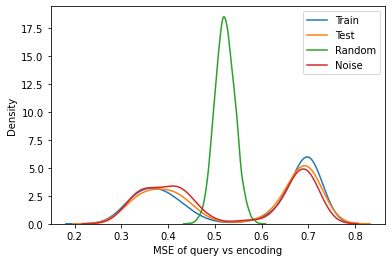

In [21]:
# Reconstruction error (x vs ae(x)) to separate out anomalies/OOD queries
mse_train = ((X_train - out_decoder_train.detach().numpy())**2).mean(axis=1)
print(mse_train.shape)
mse_test = ((X_test - out_decoder_test.detach().numpy())**2).mean(axis=1)
mse_rand = ((simulated_queries.reset_index(drop=True) - out_decoder_rand.detach().numpy())**2).mean(axis=1)
mse_noise = ((noise_queries.reset_index(drop=True) - out_decoder_noise.detach().numpy())**2).mean(axis=1)

print('Median MSE across train data', np.median(mse_train))
print('Median MSE across test data', np.median(mse_test))
print('Median MSE across random data', np.median(mse_rand))
print('Median MSE across noise-added data', np.median(mse_noise))
print('--------')
print('Variance of MSE across train data', np.var(mse_train))
print('Variance of MSE across test data', np.var(mse_test))
print('Variance of MSE across random data', np.var(mse_rand))
print('Variance of MSE across noise-added data', np.var(mse_noise))
print('--------')
q75, q25 = np.percentile(mse_train, [75 ,25])
print('IQR of MSE across train data', q75-q25)
q75, q25 = np.percentile(mse_test, [75 ,25])
print('IQR of MSE across test data', q75-q25)
q75, q25 = np.percentile(mse_rand, [75 ,25])
print('IQR of MSE across random data', q75-q25)
q75, q25 = np.percentile(mse_noise, [75 ,25])
print('IQR of MSE across noise-added data', q75-q25)

sns.kdeplot(mse_train, label='Train')
sns.kdeplot(mse_test, label='Test')
sns.kdeplot(mse_rand, label='Random')
sns.kdeplot(mse_noise, label='Noise')
plt.legend()
plt.xlabel('MSE of query vs encoding')
plt.savefig('./results/UCI_HAR/defense/mse_density.png', dpi=300)
plt.show()

## Train activity prediction model on encodings

In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=7)
clf.fit(out_encoder_train.detach().numpy(), y_train)

accuracy = clf.score(out_encoder_train.detach().numpy(), y_train)
print(f'RF train accuracy: {accuracy:.2f}')
accuracy = clf.score(out_encoder_test.detach().numpy(), y_test)
print(f'RF test accuracy: {accuracy:.2f}')

RF train accuracy: 1.00
RF test accuracy: 0.84


In [17]:
clf = LogisticRegression(random_state=0, max_iter=500, multi_class='multinomial')
clf.fit(out_encoder_train.detach().numpy(), y_train)

accuracy = clf.score(out_encoder_train.detach().numpy(), y_train)
print(f'LR train accuracy: {accuracy:.2f}')
accuracy = clf.score(out_encoder_test.detach().numpy(), y_test)
print(f'LR test accuracy: {accuracy:.2f}')

LR train accuracy: 0.94
LR test accuracy: 0.92


/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
class Net(nn.Module):
	def __init__(self, input_size, num_classes):
		super(Net, self).__init__()
		self.fc1 = nn.Linear(input_size, 128)
		# self.fc2 = nn.Linear(128, 128)
		self.fc3 = nn.Linear(128, num_classes)

	def forward(self, x):
		x = nn.functional.relu(self.fc1(x))
		# x = nn.functional.relu(self.fc2(x))
		x = self.fc3(x)
		return x

def dnn(train_loader, input_size, num_classes):
	model = Net(input_size, num_classes)

	criterion = nn.CrossEntropyLoss()
	optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
	model.train()

	# Train the model for 10 epochs
	losses = []
	for epoch in range(80):
		for x,y in train_loader:
			outputs = model(x)
			loss = criterion(outputs, y)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
		losses.append(loss)

	plt.plot(losses)
	plt.show()

	return model

def dnn_predict(model, X, y):
	model.eval()
	outputs = model(X)
	_, predicted = torch.max(outputs.data, 1)
	accuracy = (predicted == y).float().mean()

	sns.heatmap(confusion_matrix(y, predicted))
	plt.show()

	return accuracy

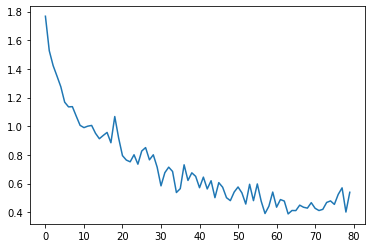

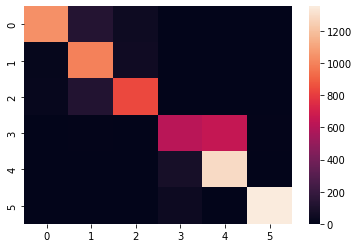

DNN train accuracy: 0.84


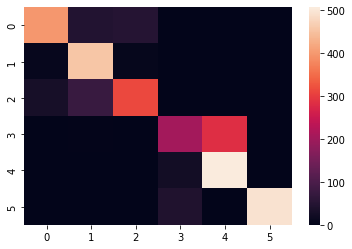

DNN test accuracy: 0.81


In [19]:
train_dataset = TensorDataset(out_encoder_train.detach(), torch.from_numpy(y_train.values).long())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
model = dnn(train_loader, 128, 6)

accuracy = dnn_predict(model, out_encoder_train.detach(), torch.from_numpy(y_train.values).long())
print(f'DNN train accuracy: {accuracy:.2f}')
accuracy = dnn_predict(model, out_encoder_test.detach(), torch.from_numpy(y_test.values).long())
print(f'DNN test accuracy: {accuracy:.2f}')

In [42]:
df_query_analysis = pd.read_csv('./results/UCI_HAR/defense/query_metrics.csv')

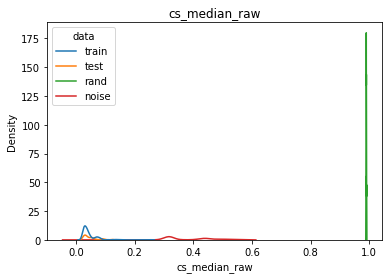

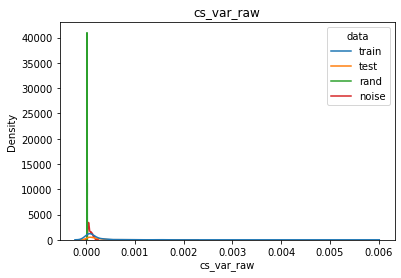

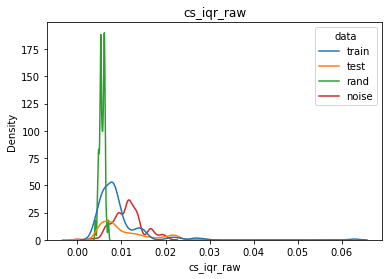

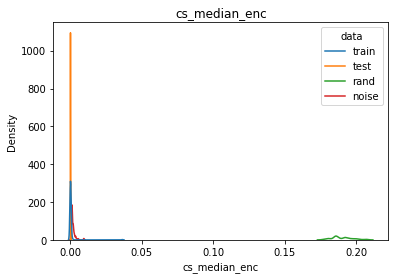

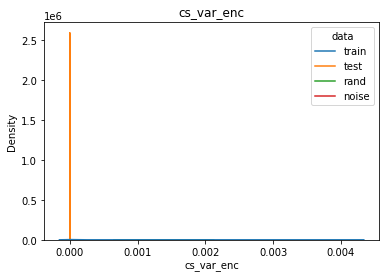

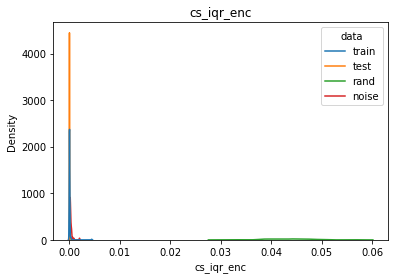

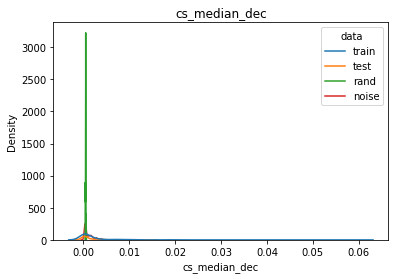

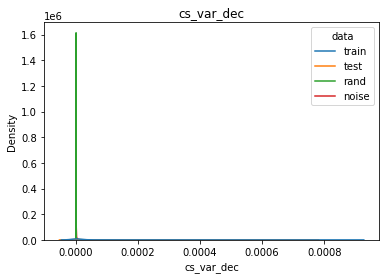

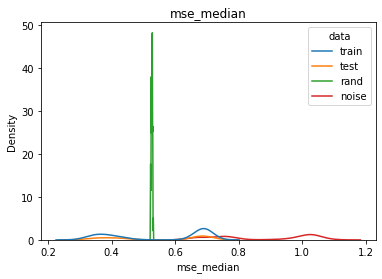

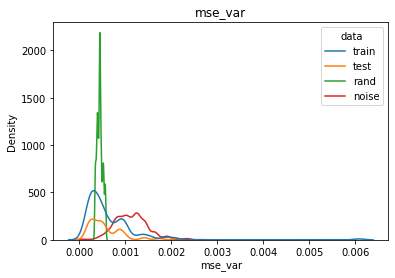

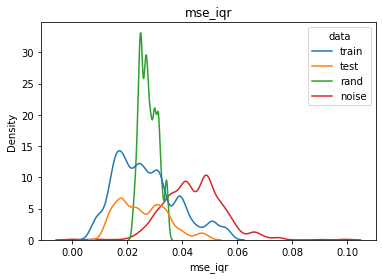

<Figure size 432x288 with 0 Axes>

In [45]:
for col in ['cs_median_raw', 'cs_var_raw', 'cs_iqr_raw', 'cs_median_enc', 'cs_var_enc', 'cs_iqr_enc', 'cs_median_dec', 'cs_var_dec', 'mse_median', 'mse_var', 'mse_iqr']:
    # for data_type in ['train', 'test', 'rand', 'noise']:
        # df_query_analysis[['data', 'class']].apply(tuple, axis=1)
    # sns.histplot(data=df_query_analysis[df_query_analysis.data == data_type], x=col, hue='class', bins=20)
    sns.kdeplot(data=df_query_analysis, x=col, hue='data')#, bins=20)
    plt.title(col)
    plt.show()
    plt.clf()